In [235]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import plot_roc_curve

# Model Selection & Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV


In [236]:
train_X = pd.read_csv("data/train_X.csv")
train_y = pd.read_csv("data/train_y.csv")
test_X = pd.read_csv("data/test_X.csv")


## Preprocessing

In [237]:
train_X.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,44939.000000,44939.000000,44939.000000,42874.000000,43288.000000,44939.000000,44308.000000,44939.000000,44939.000000,43632.000000,...,41048.000000,41048.000000,44593.000000,44593.000000,44593.000000,44593.000000,44593.000000,44593.000000,44593.000000,44593.000000
mean,65642.668751,65491.091346,105.732460,62.318701,29.195878,0.182314,169.565517,509.502659,0.836469,84.002241,...,0.085992,0.043790,0.000718,0.015541,0.223959,0.013208,0.025206,0.007064,0.004193,0.020676
std,37736.732171,37696.448956,62.901289,16.804263,8.263748,0.386107,10.788113,228.631369,2.565688,25.016278,...,0.248608,0.217667,0.026779,0.123691,0.416900,0.114167,0.156751,0.083751,0.064622,0.142298
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-13.775000,38.600000,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33059.000000,32732.000000,47.000000,52.000000,23.638493,0.000000,162.500000,369.000000,0.034722,66.700000,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65732.000000,65467.000000,109.000000,65.000000,27.680158,0.000000,170.000000,504.000000,0.138194,80.300000,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98239.500000,98089.500000,161.000000,75.000000,32.962064,0.000000,177.800000,683.000000,0.410417,97.100000,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131049.000000,131049.000000,204.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,186.000000,...,0.980000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [238]:
train_X["has_died"] = train_y

test_y = pd.DataFrame()
test_y["patient_id"] = pd.DataFrame(test_X["patient_id"])

In [239]:
train_X = train_X.drop("encounter_id", axis=1)
test_X = test_X.drop("encounter_id", axis=1)

train_X = train_X.drop("patient_id", axis=1)
test_X = test_X.drop("patient_id", axis=1)

train_X = train_X.drop("hospital_id", axis=1)
test_X = test_X.drop("hospital_id", axis=1)

train_X = train_X.drop("icu_id", axis=1)
test_X = test_X.drop("icu_id", axis=1)

train_X = train_X.drop("aids", axis=1)
test_X = test_X.drop("aids", axis=1)


In [240]:
train_X.loc[(train_X['apache_4a_hospital_death_prob'] < 0), 'apache_4a_hospital_death_prob'] = np.nan
test_X.loc[(test_X['apache_4a_hospital_death_prob'] < 0), 'apache_4a_hospital_death_prob'] = np.nan

train_X.loc[(train_X['apache_4a_icu_death_prob'] < 0), 'apache_4a_icu_death_prob'] = np.nan
test_X.loc[(test_X['apache_4a_icu_death_prob'] < 0), 'apache_4a_icu_death_prob'] = np.nan


In [241]:
train_X.describe()


,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,has_died
count,42874.000000,43288.000000,44939.000000,44308.000000,44939.000000,43632.000000,44132.000000,44389.000000,44939.000000,44593.000000,...,39863.000000,39949.000000,44593.000000,44593.000000,44593.000000,44593.000000,44593.000000,44593.000000,44593.000000,44939.000000
mean,62.318701,29.195878,0.182314,169.565517,0.836469,84.002241,185.664461,557.204029,0.199760,0.028031,...,0.118275,0.072504,0.015541,0.223959,0.013208,0.025206,0.007064,0.004193,0.020676,0.086295
std,16.804263,8.263748,0.386107,10.788113,2.565688,25.016278,86.099766,462.843578,0.399824,0.165064,...,0.165955,0.133734,0.123691,0.416900,0.114167,0.156751,0.083751,0.064622,0.142298,0.280802
min,16.000000,14.844926,0.000000,137.200000,-13.775000,38.600000,101.000000,0.020000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.000000,23.638493,0.000000,162.500000,0.034722,66.700000,113.000000,203.010000,0.000000,0.000000,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65.000000,27.680158,0.000000,170.000000,0.138194,80.300000,122.000000,409.020000,0.000000,0.000000,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,32.962064,0.000000,177.800000,0.410417,97.100000,301.000000,703.030000,0.000000,0.000000,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,89.000000,67.814990,1.000000,195.590000,159.090972,186.000000,308.000000,2201.050000,1.000000,1.000000,...,0.980000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Encoding

In [242]:
train_X["ethnicity"].head()

0               Asian
1           Caucasian
2    African American
3            Hispanic
4           Caucasian
Name: ethnicity, dtype: object

In [243]:
train_X = train_X.dropna(
    subset=[
        "ethnicity",
        "gender",
        "icu_admit_source",
        "icu_stay_type",
        "icu_type",
        "apache_3j_bodysystem",
        "apache_2_bodysystem"
    ]
)


In [244]:
columns = []
for i in train_X.columns:
    if train_X[i].dtype == "object":
        columns.append(i)

print(columns)


['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']


In [245]:
for dataset in [train_X, test_X]:
    for col in columns:
        le = LabelEncoder()
        dataset[col] = le.fit_transform(dataset[col])


In [246]:
train_X["ethnicity"].head()

0    1
1    2
2    0
3    3
4    2
Name: ethnicity, dtype: int64

## Training

In [247]:
train_y = pd.DataFrame(train_X["has_died"])
train_X = train_X.drop("has_died", axis=1)


In [248]:
train_data, valid_data, train_label, valid_label = train_test_split(
    train_X, train_y, train_size=0.7, test_size=0.3, stratify=train_y
)


In [48]:
# opt = BayesSearchCV(
#     estimator = XGBClassifier(
#         objective = 'binary:logistic',
#         scale_pos_weight=10,
#         tree_method='gpu_hist',
#         gpu_id=0
#     ),
#     search_spaces = {
#         'learning_rate': (0.01, 1.0, 'log-uniform'),
#         'min_child_weight': (0, 10),
#         'max_depth': (0, 50),
#         'max_delta_step': (0, 20),
#         'subsample': (0.01, 1.0, 'uniform'),
#         'colsample_bytree': (0.01, 1.0, 'uniform'),
#         'colsample_bylevel': (0.01, 1.0, 'uniform'),
#         'reg_alpha': (1e-9, 1.0, 'log-uniform'),
#         'gamma': (1e-9, 0.5, 'log-uniform'),
#         'n_estimators': (50, 1000),
#     },    
#     scoring = 'f1_macro',
#     cv = StratifiedKFold(
#         n_splits=3,
#         shuffle=True,
#         random_state=42
#     ),
#     n_jobs = 3,
#     n_iter = 3,
#     random_state = 42
# )

# result = opt.fit(train_X.values, train_y.values)


/home/me/.conda/envs/py39/lib/python3.9/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/me/.conda/envs/py39/lib/python3.9/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/me/.conda/envs/py39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/me/.conda/envs/py39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

In [49]:
# result.best_params_


OrderedDict([('colsample_bylevel', 0.4160029192647807),
             ('colsample_bytree', 0.7304484857455519),
             ('gamma', 0.13031389926541354),
             ('learning_rate', 0.042815319280763466),
             ('max_delta_step', 13),
             ('max_depth', 21),
             ('min_child_weight', 4),
             ('n_estimators', 753),
             ('reg_alpha', 5.497557739289786e-07),
             ('subsample', 0.6513136724634089)])

In [220]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    return "f1-error", 1 - f1_score(y_true=y_true, y_pred=y_pred_binary, average="macro")

xgb = XGBClassifier(
    learning_rate=0.042815319280763466,
    gamma=0.13031389926541354,
    max_depth=21,
    min_child_weight=4,
    max_delta_step=13,
    alpha=5.497557739289786e-07,
    subsample=0.6513136724634089,
    colsample_bytree=0.7304484857455519,
    colsample_bylevel=0.4160029192647807,
    tree_method="gpu_hist",
    gpu_id=0,
    scale_pos_weight=10,
    objective="binary:logistic",
    disable_default_eval_metric=True,
    n_estimators=753,
)
xgb.fit(train_data, train_label, eval_metric=f1_eval, early_stopping_rounds=20, eval_set=[(train_data, train_label), (valid_data, valid_label)])

train_pred = xgb.predict(train_data)
valid_pred = xgb.predict(valid_data)
valid_pred_prob = xgb.predict_proba(valid_data)


/home/me/.conda/envs/py39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/me/.conda/envs/py39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/me/.conda/envs/py39/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-f1-error:0.52257	validation_1-f1-error:0.52258
Multiple eval metrics have been passed: 'validation_1-f1-error' will be used for early stopping.

Will train until validation_1-f1-error hasn't improved in 20 rounds.
[1]	validation_0-f1-error:0.52257	validation_1-f1-error:0.52258
[2]	validation_0-f1-error:0.52257	validation_1-f1-error:0.52258
[3]	validation_0-f1-error:0.52257	validation_1-f1-error:0.52258
[4]	validation_0-f1-error:0.52257	validation_1-f1-error:0.52258
[5]	validation_0-f1-error:0.52257	validation_1-f1-error:0.52258
[6]	validation_0-f1-error:0.46503	validation_1-f1-error:0.48046
[7]	validation_0-f1-error:0.35569	validation_1-f1-error:0.42550
[8]	validation_0-f1-error:0.30614	validation_1-f1-error:0.39799
[9]	validation_0-f1-error:0.25739	validation_1-f1-error:0.37528
[10]	validation_0-f1-error:0.23056	validation_1-f1-error:0.36502
[11]	validation_0-f1-error:0.20453	validation_1-f1-error:0.35547
[12]	validation_0-f1-error:0.18531	validation_1-f1-error:0.3459

/home/me/.conda/envs/py39/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [221]:
importances = pd.DataFrame(
    {"feature": train_data.columns, "importance": np.round(xgb.feature_importances_, 5)}
)
importances = importances.sort_values("importance", ascending=False)

importances.to_csv("data/importances.csv", index=False)
importances


,feature,importance
24,ventilated_apache,0.08268
68,apache_4a_icu_death_prob,0.06063
67,apache_4a_hospital_death_prob,0.04499
18,gcs_verbal_apache,0.04204
16,gcs_motor_apache,0.03064
...,...,...
20,intubated_apache,0.00626
76,apache_3j_bodysystem,0.00612
70,diabetes_mellitus,0.00576
4,gender,0.00556


## Evaluation

training F1 score: 0.9828740630651926
validation F1 score: 0.7304793553381124
training precision: 0.9697457930540637
validation precision: 0.7413946078431373
training recall: 0.9969555035128805
validation recall: 0.7207964130587081


/home/me/.conda/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/me/.conda/envs/py39/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/me/.conda/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :me

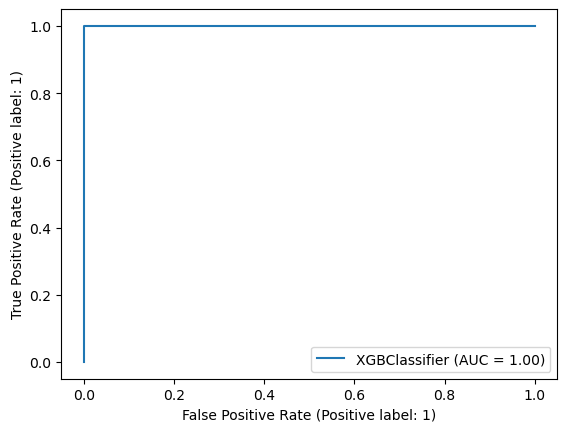

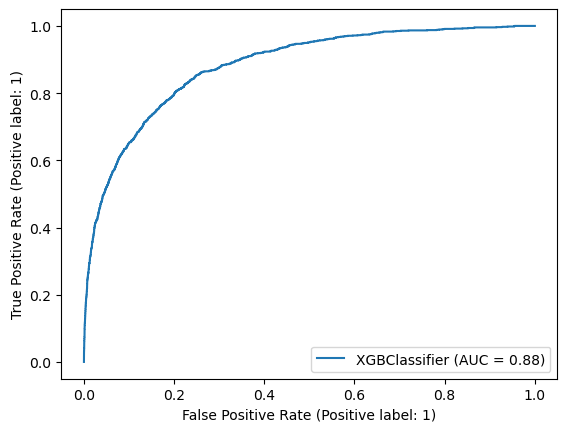

In [227]:
print("training F1 score:", f1_score(train_label, train_pred, average="macro"))
print("validation F1 score:", f1_score(valid_label, valid_pred, average="macro"))
print("training precision:", precision_score(train_label, train_pred, average="macro"))
print("validation precision:", precision_score(valid_label, valid_pred, average="macro"))
print("training recall:", recall_score(train_label, train_pred, average="macro"))
print("validation recall:", recall_score(valid_label, valid_pred, average="macro"))

plot_roc_curve(xgb, train_data, train_label)
plot_roc_curve(xgb, valid_data, valid_label)

## Generate Result

In [265]:
test_pred = xgb.predict(test_X)
test_y["pred"] = test_pred
test_y = test_y.sort_values(["patient_id"], ignore_index=True)
test_y.head()

/home/me/.conda/envs/py39/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


,patient_id,pred
0,7,0
1,8,0
2,18,0
3,22,0
4,30,0


In [266]:
test_y.to_csv("data/testing_result.csv", index=False)